# Problem 1: The Eight Schools

Students at eight schools each participated in a test-prep program. After examination, the average score improvement $ \Delta S$ for each school was recorded, along with the uncertainty on this measurement $ \sigma( \Delta S)$:

   + $ \Delta S$ = [28, 8, -3, 7, -1, 1, 18, 12]

   + $ \sigma( \Delta S$) = [15, 10, 16, 11, 9, 11, 10, 18]


a) Calculate the pooled mean improvement and uncertainty on the mean

b) Fit the data using a hierarchical modeling. Assuming the score improvements $\theta = \Delta S$ were drawn from a population that can be modeled as a Gaussian with mean $\mu$ and uncertainty $\sigma$.

* i. Draw your hyperparameters $\alpha = \{\mu, \sigma\}$ from a Gaussian and Half-Cauchy distribution, respectively
* ii. Test other choices of distributions for the hyper-priors and population. How sensitive are the results?

Sample from the posterior using a sampling method of your choice. Test the sampler runs for convergence. Explore sampler behavior when using centered vs. off-centered parameterization.

In [5]:
import numpy as np

delta_s=np.array([28, 8, -3, 7, -1, 1, 18, 12],dtype=float)
sigma=np.array([15, 10, 16, 11, 9, 11, 10, 18],dtype=float)

pool_delta_s=np.average(delta_s,weights=1/sigma**2)
pool_unc=np.sqrt(np.sum(np.square(sigma))/len(sigma))
pool_unc=np.sqrt(1/np.sum(1/sigma**2))

print(f"Weighted average of delta_s: {pool_delta_s:.2f} +/- {pool_unc:.2f}")

Weighted average of delta_s: 7.69 +/- 4.07


In [14]:
from scipy.stats import halfcauchy,norm


#priors for the population
mu_population=norm(pool_delta_s, pool_unc).rvs(10000)
std_population=halfcauchy(pool_unc).rvs(10000)

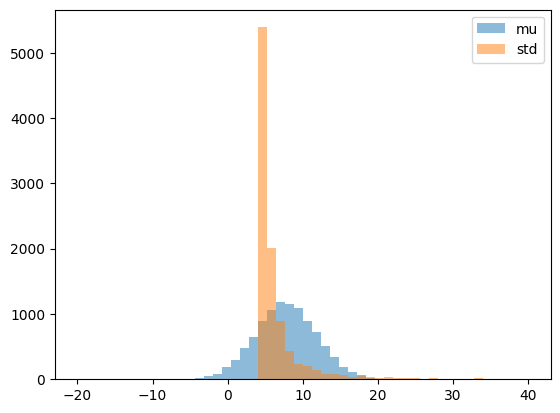

In [16]:
import matplotlib.pyplot as plt
plt.hist(mu_population, bins=50, alpha=0.5, label='mu',range=(-20,40))
plt.hist(std_population, bins=50, alpha=0.5, label='std',range=(-20,40))
plt.legend()

In [18]:
import pymc as pm

In [28]:
with pm.Model() as model:
    # draw population {mu,sd} hierarchically
    mu_pop = pm.Normal('mu_pop', mu=pool_delta_s, sigma=pool_unc)
    sd_pop = pm.HalfCauchy('sd_pop', beta=pool_unc)
    # compute the likelihood using measured dscore {mu, sd}
    lnlike = pm.Normal('lnlike', mu=mu_pop, sigma=sd_pop, observed=delta_s)

    # draw samples from the posterior
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, sd_pop]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'mu_pop'}>,
        <Axes: title={'center': 'mu_pop'}>],
       [<Axes: title={'center': 'sd_pop'}>,
        <Axes: title={'center': 'sd_pop'}>]], dtype=object)

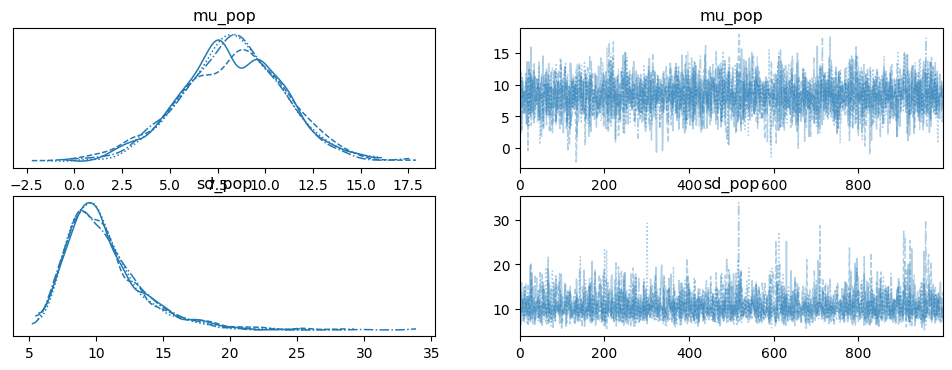

In [29]:
import arviz as az
az.plot_trace(trace, var_names=["mu_pop", "sd_pop"])

Changing priors!

In [30]:
with pm.Model() as model:
    # draw population {mu,sd} hierarchically
    mu_pop_uni = pm.Uniform('mu_pop_uni', rng=[min(delta_s), max(delta_s)])
    sd_pop = pm.HalfCauchy('sd_pop', beta=pool_unc)
    # compute the likelihood using measured dscore {mu, sd}
    lnlike = pm.Normal('lnlike', mu=mu_pop_uni, sigma=sd_pop, observed=delta_s)

    # draw samples from the posterior
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop_uni, sd_pop]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


array([[<Axes: title={'center': 'mu_pop_uni'}>,
        <Axes: title={'center': 'mu_pop_uni'}>],
       [<Axes: title={'center': 'sd_pop'}>,
        <Axes: title={'center': 'sd_pop'}>]], dtype=object)

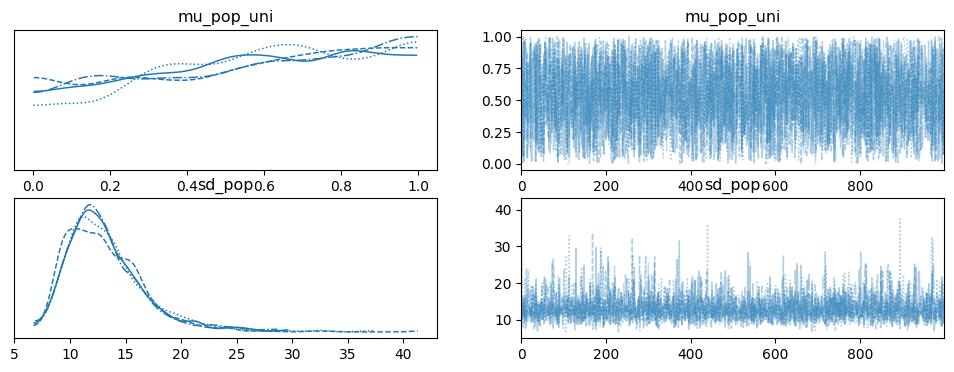

In [31]:
import arviz as az
az.plot_trace(trace, var_names=["mu_pop_uni", "sd_pop"])

Offcentered vs centered parameterizations

In [41]:
with pm.Model() as model:
    # use off-centered parameterization
    dscore_off = pm.Normal('dscore_off', mu=0, sigma=1, shape=len(delta_s))
    dscore_mod = pm.Deterministic('dscore_mod', pool_delta_s + pool_unc*dscore_off)
    # compute the likelihood using measured dscore {mu, sd}
    lnlike = pm.Normal('lnlike', mu=dscore_mod, sigma=sigma, observed=delta_s)

    # draw samples from the posterior
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dscore_off]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


array([[<Axes: title={'center': 'dscore_off'}>,
        <Axes: title={'center': 'dscore_off'}>],
       [<Axes: title={'center': 'dscore_mod'}>,
        <Axes: title={'center': 'dscore_mod'}>]], dtype=object)

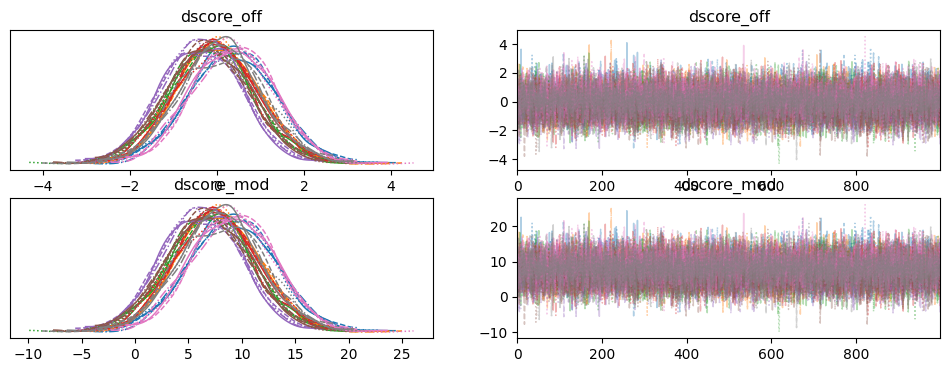

In [43]:
import arviz as az
az.plot_trace(trace)

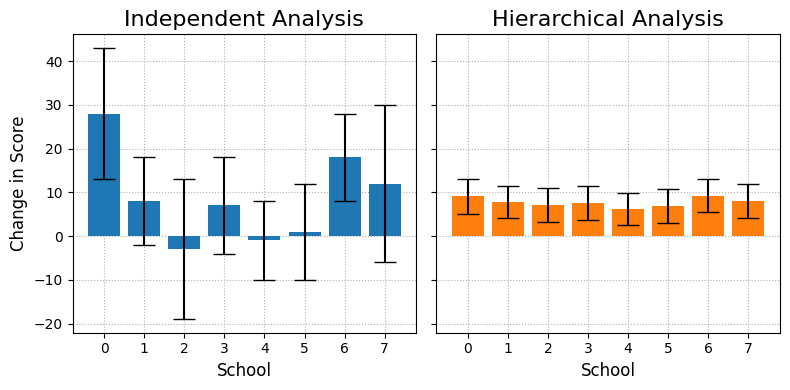

In [46]:
nschool = len(delta_s)
dscore_hbayes_mu = np.mean(np.array(trace.posterior.dscore_mod).reshape((-1,nschool)), axis=0)
dscore_hbayes_sd = np.std(np.array(trace.posterior.dscore_mod).reshape((-1,nschool)), axis=0)

fig, ax = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

ax[0].bar(np.arange(nschool), delta_s, yerr=sigma, zorder=3, capsize=8)
ax[0].grid(zorder=0, ls=':')
ax[0].set_xticks(np.arange(nschool))
ax[0].set_xlabel("School", fontsize=12)
ax[0].set_ylabel(r"Change in Score", fontsize=12)
ax[0].set_title("Independent Analysis", fontsize=16)

ax[1].bar(np.arange(nschool), dscore_hbayes_mu, yerr=dscore_hbayes_sd, color='C1', zorder=3, capsize=8)
ax[1].grid(zorder=0, ls=':')
ax[1].set_xlabel("School", fontsize=12)
ax[1].set_title("Hierarchical Analysis", fontsize=16)

plt.tight_layout()
plt.show()

# Problem 2: The Five Districts

The test-prep program was expanded across five districts, for a total of 27 schools. For each school, the mean score improvement, uncertainty on the mean, and number of hours each student spent studying was recorded.

### Exercises

a) Load the Five Districts dataset (five_districts.csv) and plot the data
b) Determine the expected score improvement per hour studied for each school using three different models:

+ i. A fully pooled model
+ ii. Independent estimates for each district
+ iii. A hierarchical model that asserts a relationship between the schools and districts.

For all three cases, sample from the posterior using a sampling method of your choice. Test the sampler runs for convergence. Explore sampler behavior when using centered vs. off-centered parameterization.

For the third option, draw the relationship as a directed acyclic graph. Justify your choices of distributions for parameters and hyper-parameters, and test your results for sensitivity to modeling choices.


# Problem 3: Dyson Spheres

Congratulations! You've detected a strange class of objects that you suspect are [Dyson spheres](https://en.wikipedia.org/wiki/Dyson_sphere). Your data are sparse, but you nonetheless detect hints of variability in each object's brightness.

a) Load the Dyson Sphere dataset (dyson_spheres.csv) and plot the time series data. What do you notice about the relative amplitude variations?

b) For each object, compute a Lomb-Scargle periodogram. What do you notice about the frequency-power plot?

c) Assume that each object's time series can be modeled as a single-component sinusoid. Construct a hierarchical model for the population, asserting some population-level relationship between the amplitudes, frequencies, and phases for each object's sinusoid. Which parameters might be expected to be correlated or independent of one another?

# Problem 4: Astrophysics

Select an astrophysical dataset of your choosing. Describe any hierarchical structure in the data using a directed acyclic graph. Build a simple hierarchical model for the data. You may wish to use only a few member objects of your dataset in order to more rapidly iterate while developing.